In [1]:
import json
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import os
import random
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import timm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

data_dir = "/kaggle/input/x-ray-bone-fracture-dataset/X-ray Bone Fracture Dataset Comprehensive Imaging for Fracture Classification and Medical Research/Bone -Fracture/Bone Fracture/Orginal"


# Load Dataset

In [2]:
data_dir = "/kaggle/input/x-ray-bone-fracture-dataset/X-ray Bone Fracture Dataset Comprehensive Imaging for Fracture Classification and Medical Research/Bone -Fracture/Bone Fracture/Orginal"

from torchvision import datasets
full_dataset = datasets.ImageFolder(root=data_dir)
dataset_size = len(full_dataset)
targets = full_dataset.targets  # list of labels


# Split the dataset (Train, Test, Validation)

In [3]:
indices = list(range(dataset_size))

train_indices, temp_indices = train_test_split(
    indices, test_size=0.2, stratify=[targets[i] for i in indices], random_state=SEED)


In [4]:
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[targets[i] for i in temp_indices], random_state=SEED)


# Split Train (Label, Unlabel)

In [5]:
train_targets = [targets[i] for i in train_indices]
num_train = len(train_indices)
num_labeled = int(0.4* num_train)

random.seed(SEED)
shuffled_train_indices = train_indices.copy()
random.shuffle(shuffled_train_indices)

labeled_indices = shuffled_train_indices[:num_labeled]
unlabeled_indices = shuffled_train_indices[num_labeled:]


In [6]:
splits = {
    "train": train_indices,
    "val": val_indices,
    "test": test_indices,
    "train_labeled": labeled_indices,
    "train_unlabeled": unlabeled_indices
}

output_path = "./splits.json"  # current notebook directory
with open(output_path, "w") as f:
    json.dump(splits, f)

print(f"Saved splits.json with {len(train_indices)} train, {len(val_indices)} val, {len(test_indices)} test samples.")
print(f"Labeled train: {len(labeled_indices)} samples, Unlabeled train: {len(unlabeled_indices)} samples")


Saved splits.json with 1907 train, 238 val, 239 test samples.
Labeled train: 762 samples, Unlabeled train: 1145 samples


# Transformation

In [7]:
# Base transform for validation and labeled data
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Weak augmentation (like base but with random flip)
weak_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),                
    transforms.ColorJitter(brightness=0.3,     
                           contrast=0.3,
                           saturation=0.3,
                           hue=0.1),
    
   
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    
])

# Strong augmentation (RandAugment or similar)
from torchvision.transforms import RandAugment

strong_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandAugment(), 
    transforms.RandomRotation(15),               
    transforms.ColorJitter(brightness=0.3,       
                           contrast=0.3,
                           saturation=0.3,
                           hue=0.1),
   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
                             
])


# Create Subsets from full dataset

In [8]:
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

labeled_subset = Subset(full_dataset, labeled_indices)
unlabeled_subset = Subset(full_dataset, unlabeled_indices)


# Custom Dataset

In [9]:
class LabeledDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

class UnlabeledDataset(Dataset):
    def __init__(self, subset, weak_transform=None, strong_transform=None):
        self.subset = subset
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        img, _ = self.subset[idx]
        weak_img = self.weak_transform(img) if self.weak_transform else img
        strong_img = self.strong_transform(img) if self.strong_transform else img
        return weak_img, strong_img


# Instantiate Datasets with Transforms

In [10]:
labeled_dataset = LabeledDataset(labeled_subset, transform=base_transform)
unlabeled_dataset = UnlabeledDataset(unlabeled_subset, weak_transform=weak_transform, strong_transform=strong_transform)
val_dataset = LabeledDataset(val_subset, transform=base_transform)
test_dataset = LabeledDataset(test_subset, transform=base_transform)


# Data Loader

In [11]:
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Define Model, Freeze Backbone, Optimizer

In [12]:
num_classes = len(full_dataset.classes)

# Change backbone to ViT-Base-16
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)
model = model.to(device)

def freeze_backbone(model, freeze=True):
    total_params = len(list(model.parameters()))
    freeze_count = int(0.25 * total_params)
    for i, param in enumerate(model.parameters()):
        param.requires_grad = not (freeze and i < freeze_count)

# Freeze first 25% of layers
freeze_backbone(model, freeze=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# Validation Function

In [13]:
def validate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    return acc, prec, rec, f1


# Training Loop(Fix Match)

In [14]:
num_epochs = 75
freeze_epochs = 5
tau = 0.9
lambda_u = 1.0

train_sup_losses = []
train_unsup_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(1, num_epochs+1):
    model.train()
    
    if epoch == freeze_epochs + 1:
        freeze_backbone(model, freeze=False)
        print(f"Epoch {epoch}: Unfroze backbone layers")
    
    sup_loss_running = 0.0
    unsup_loss_running = 0.0
    batches = 0
    
    for (x_labeled, y_labeled), (x_unl_weak, x_unl_strong) in zip(labeled_loader, unlabeled_loader):
        x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
        x_unl_weak, x_unl_strong = x_unl_weak.to(device), x_unl_strong.to(device)
        
        optimizer.zero_grad()
        
        # Supervised loss
        logits_labeled = model(x_labeled)
        loss_sup = F.cross_entropy(logits_labeled, y_labeled)
        
        # Pseudo-label generation on weak augmented unlabeled images
        with torch.no_grad():
            preds_unl_weak = F.softmax(model(x_unl_weak), dim=1)
            max_probs, pseudo_labels = torch.max(preds_unl_weak, dim=1)
            mask = (max_probs >= tau).float()
        
        # Unsupervised loss on strong augmented images
        logits_unl_strong = model(x_unl_strong)
        loss_unsup_all = F.cross_entropy(logits_unl_strong, pseudo_labels, reduction='none')
        loss_unsup = (loss_unsup_all * mask).mean()
        
        loss = loss_sup + lambda_u * loss_unsup
        loss.backward()
        optimizer.step()
        
        sup_loss_running += loss_sup.item()
        unsup_loss_running += loss_unsup.item()
        batches += 1
    
    avg_sup_loss = sup_loss_running / batches
    avg_unsup_loss = unsup_loss_running / batches
    
    train_sup_losses.append(avg_sup_loss)
    train_unsup_losses.append(avg_unsup_loss)
    
    val_acc, val_prec, val_rec, val_f1 = validate(model, val_loader)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1s.append(val_f1)
    
    print(f"Epoch {epoch}/{num_epochs} | Sup Loss: {avg_sup_loss:.4f} | Unsup Loss: {avg_unsup_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f} | Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val F1: {val_f1:.4f}")


Epoch 1/75 | Sup Loss: 1.0542 | Unsup Loss: 0.0081
Val Acc: 0.5588 | Val Prec: 0.5588 | Val Rec: 0.5588 | Val F1: 0.5566
Epoch 2/75 | Sup Loss: 0.6566 | Unsup Loss: 0.0000
Val Acc: 0.5378 | Val Prec: 0.5376 | Val Rec: 0.5378 | Val F1: 0.5339
Epoch 3/75 | Sup Loss: 0.6547 | Unsup Loss: 0.0001
Val Acc: 0.5378 | Val Prec: 0.5884 | Val Rec: 0.5378 | Val F1: 0.4725
Epoch 4/75 | Sup Loss: 0.6444 | Unsup Loss: 0.0004
Val Acc: 0.5756 | Val Prec: 0.5813 | Val Rec: 0.5756 | Val F1: 0.5639
Epoch 5/75 | Sup Loss: 0.6381 | Unsup Loss: 0.0018
Val Acc: 0.5504 | Val Prec: 0.5507 | Val Rec: 0.5504 | Val F1: 0.5462
Epoch 6: Unfroze backbone layers
Epoch 6/75 | Sup Loss: 0.7815 | Unsup Loss: 0.0026
Val Acc: 0.4790 | Val Prec: 0.4078 | Val Rec: 0.4790 | Val F1: 0.3389
Epoch 7/75 | Sup Loss: 0.7213 | Unsup Loss: 0.0012
Val Acc: 0.5126 | Val Prec: 0.7553 | Val Rec: 0.5126 | Val F1: 0.3690
Epoch 8/75 | Sup Loss: 0.6957 | Unsup Loss: 0.0000
Val Acc: 0.5546 | Val Prec: 0.5549 | Val Rec: 0.5546 | Val F1: 0.5508

# Plot Training Curves

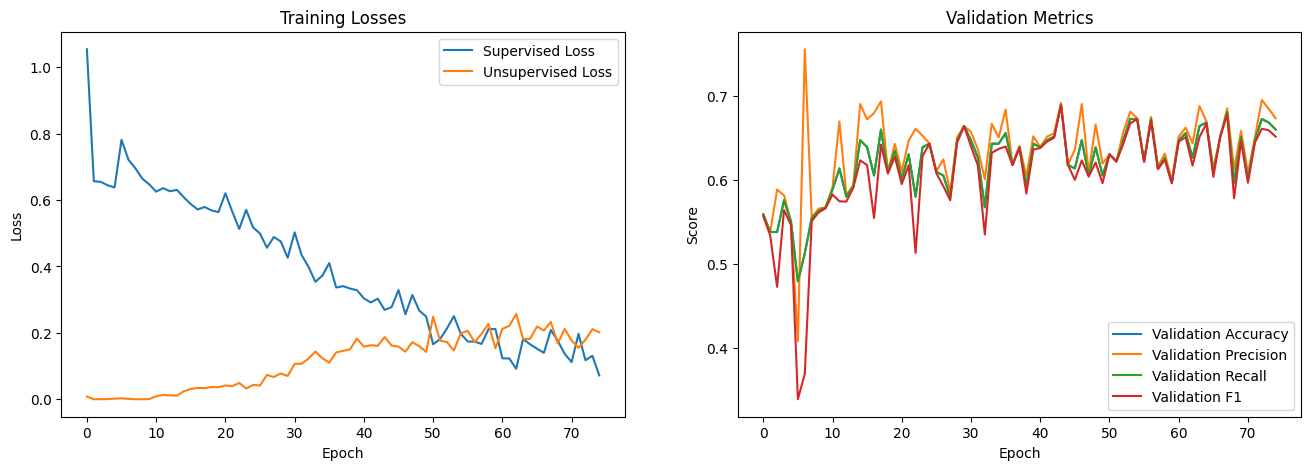

In [15]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(train_sup_losses, label='Supervised Loss')
plt.plot(train_unsup_losses, label='Unsupervised Loss')
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_precisions, label='Validation Precision')
plt.plot(val_recalls, label='Validation Recall')
plt.plot(val_f1s, label='Validation F1')
plt.title("Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.show()


# Classification Report

In [16]:
import pandas as pd
from sklearn.metrics import classification_report

def display_classification_report(model, dataloader, device, target_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    report_dict = classification_report(all_labels, all_preds, target_names=target_names, zero_division=0, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    
    print(df_report)   # Text print
    display(df_report) # Nice table display (in Jupyter notebooks)
    return df_report

# Usage:
class_names = full_dataset.classes
display_classification_report(model, val_loader, device, target_names=class_names)


                          precision    recall  f1-score     support
Comminuted Bone Fracture   0.719512  0.504274  0.592965  117.000000
Simple Bone Fracture       0.628205  0.809917  0.707581  121.000000
accuracy                   0.659664  0.659664  0.659664    0.659664
macro avg                  0.673859  0.657095  0.650273  238.000000
weighted avg               0.673091  0.659664  0.651236  238.000000


,precision,recall,f1-score,support
Comminuted Bone Fracture,0.719512,0.504274,0.592965,117.000000
Simple Bone Fracture,0.628205,0.809917,0.707581,121.000000
accuracy,0.659664,0.659664,0.659664,0.659664
macro avg,0.673859,0.657095,0.650273,238.000000
weighted avg,0.673091,0.659664,0.651236,238.000000


,precision,recall,f1-score,support
Comminuted Bone Fracture,0.719512,0.504274,0.592965,117.000000
Simple Bone Fracture,0.628205,0.809917,0.707581,121.000000
accuracy,0.659664,0.659664,0.659664,0.659664
macro avg,0.673859,0.657095,0.650273,238.000000
weighted avg,0.673091,0.659664,0.651236,238.000000
